In [1]:
!pip install pmdarima --quiet

You should consider upgrading via the 'c:\users\admin\pycharmprojects\kurs4_2\venv\scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
!pip install statsmodels==0.11.0rc1 --quiet
#!pip install -Iv pulp==1.6.8 --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pmdarima 1.8.0 requires statsmodels!=0.12.0,>=0.11, but you have statsmodels 0.11.0rc1 which is incompatible.
You should consider upgrading via the 'c:\users\admin\pycharmprojects\kurs4_2\venv\scripts\python.exe -m pip install --upgrade pip' command.


In [3]:
import yfinance as yf
import statistics

# Scrape data from Yahoo Finance
stock_name = 'TSLA'
data = yf.download(stock_name, start="2020-03-26", end="2021-03-29")
hist_data = yf.download(stock_name, start="2021-04-01", end="2021-05-04")
hist_data = hist_data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
hist_data = hist_data['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
from sklearn.preprocessing import MinMaxScaler
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM

def lstm(stock_name, data, hist_data_new):
    
    # Extract Close value of stock data for predicting
    data = data.filter(['Close'])
    dataset = data.values
    
    # Train data volume - 80%, test - 20%
    training_data_len = int(np.ceil( len(dataset) * .80 ))
    
    # Scale the data from 0 to 1 (minmax)
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)
    train_data = scaled_data[0:int(training_data_len), :]
    x_train = []
    y_train = []

    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    # Build LSTM model
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape = (x_train.shape[1], 1)))
    model.add(Dropout(0.35))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(25, activation = 'relu'))
    model.add(Dense(1))
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

    # Structure of the model
    keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)
    
    # Train the model
    model.fit(x_train, y_train, batch_size=1, epochs=21)
    

    # Create test data for training
    test_data = scaled_data[training_data_len - 60: , :]
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])

    x_test = np.array(x_test)

    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

    # Predict on test values
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    # Root mean squared error
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    print(rmse)
    
    # Graphs
    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid['Predictions'] = predictions
    plt.figure(figsize=(16,6))
    plt.title('Model LSTM')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price', fontsize=18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()
    
    # Predict stock values for next trading month
    data_new = yf.download(stock_name, start="2021-03-01", end="2021-04-30")

    data_new = data_new.filter(['Close'])
    dataset = data_new.values
    training_data_len = len(dataset)

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)

    test_data = scaled_data[training_data_len - len(data_new): , :]
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(20, len(test_data)):
        x_test.append(test_data[i-20:i, 0])

    x_test = np.array(x_test)

    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

    hist_data_new = np.array(hist_data_new)
    pred_lstm = model.predict(x_test)
    pred_lstm = scaler.inverse_transform(pred_lstm)
    plt.figure(figsize=(10, 6))
    plt.grid(True)
    plt.ylabel(f'Prices {stock_name}')
    plt.plot(pred_lstm, label = 'predicted')
    plt.plot(hist_data_new, label = 'historical')
    plt.title(f'{stock_name} LSTM predicted price')
    plt.legend()
    plt.show()
    
    return pred_lstm

In [5]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
import random

def arima(stock_name, data, hist_data):
    df_close = data['Close']
    # Test for staionarity
    def test_stationarity(timeseries):
        # Determing rolling statistics
        rolmean = timeseries.rolling(12).mean()
        rolstd = timeseries.rolling(12).std()

        print("Results of ADF test")
        adft = adfuller(timeseries, autolag='AIC')
        # output for dft will give us without defining what the values are.
        # hence we manually write what values does it explains using a for loop
        output = pd.Series(adft[0:4],
                           index=['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
        for key, values in adft[4].items():
            output['critical value (%s)' % key] = values

    test_stationarity(df_close)

    # split data into train and training set
    df_log = df_close
    train_data, test_data = df_log[3:int(len(df_log) * 1.0)], df_log[int(len(df_log) * 1.0):]
    test_values = len(df_log) * 0.01 + 1.0

    # print(model_autoARIMA.summary())
    # p, d, q taken (3,1,2) from paper references 
    model = ARIMA(train_data, order=(3, 1, 2)) 
    arima_model = model.fit(disp=-1)
    print(arima_model.summary())
    
    print('################ forecast next ################')
    preds, se, conf = arima_model.forecast(23, alpha=0.05)
    preds = np.vstack(preds)
    hist_data = np.array(hist_data)
    plt.plot(hist_data, label='historical')
    plt.plot(preds, label='predictions')
    plt.title(f'{stock_name} ARIMA prediction for 30 days')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

    return preds

In [6]:
import numpy as np
import math
from numpy import linalg as la
import matplotlib.pyplot as plt
import math
import pandas as pd
import yfinance as yf
import statistics as stat
from scipy.special import ndtri
from scipy.stats import norm
import random
from sklearn.metrics import mean_squared_error

mu, sig, N = 1.1, 1, 100000
pts = []


def q(x):
    return (1 / (math.sqrt(2 * math.pi * sig ** 2))) * (math.e ** (-((x - mu) ** 2) / (2 * sig ** 2)))

def MCMC(n):
    r = np.zeros(1)
    p = q(r[0])
    pts = []

    for i in range(N):
        rn = r + np.random.uniform(-1, 1)
        pn = q(rn[0])
        if pn >= p:
            p = pn
            r = rn
        else:
            u = np.random.rand()
            if u < pn / p:
                p = pn
                r = rn
        pts.append(r)

    pts = random.sample(pts, len(pts))
    pts = np.array(pts)
    
    return pts

def MH(stock_name, data, hist_data):
    hist_data = np.array(hist_data)
    stock_pred = []
    data = data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
    dt1 = data['Close']
    maturnity = 1
    volatility = 0.25
    risk_free = 0.1
    timestep = 1
    steps = 23
    delta_t = maturnity / steps
    i = 0
    stock_pred.append(dt1[-1])
    while timestep < steps:
        stock_price = stock_pred[-i]
        time_exp = maturnity - delta_t * timestep
        pts = MCMC(N)
        stock_price = stock_price * math.exp(((risk_free - 0.5 * (
            math.pow(volatility, 2))) * delta_t + volatility * math.sqrt(delta_t) * pts[timestep + 5]))
        stock_pred.append(stock_price)
        i = i + 1
        timestep = timestep + 1
    
    rmse = math.sqrt(mean_squared_error(hist_data, stock_pred))
    print(rmse)
    
    plt.plot(stock_pred, label='predictions')
    plt.plot(hist_data, label = 'historical')
    plt.title(f'{stock_name} MCMC prediction for 30 days')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()
    
    return stock_pred

In [7]:
import pulp as plp

def predict_stock(stock_name):
    
    data = yf.download(stock_name, start="2020-03-26", end="2021-03-29")
    hist_data = yf.download(stock_name, start="2021-04-01", end="2021-05-04")
    hist_data = hist_data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
    hist_data = hist_data['Close']
    
    lstm_pred = lstm(stock_name, data, hist_data)
    
    arima_pred = arima(stock_name, data, hist_data)
    
    mcmc_pred = MH(stock_name, data, hist_data)
    mcmc_pred = np.vstack(mcmc_pred)
    
    hist_data = np.array(hist_data)

    preds = []
    mse = []
    weight_mcmc = 0.3
    weight_arima = 0.4
    weights_lstm = 0.4

    # weights solver
    model = plp.LpProblem('Optimal_weights', plp.LpMinimize)
    # weights--->variables
    weight_mcmc = plp.LpVariable("weight_mcmc", lowBound=0.02, upBound=0.6)
    weight_arima = plp.LpVariable("weight_arima", lowBound=0.02, upBound=0.6)
    weight_lstm = plp.LpVariable("weight_lstm", lowBound=0.02, upBound=0.6)

    for i in range(len(hist_data)):
        preds.append(mcmc_pred[i]*weight_mcmc + arima_pred[i]*weight_arima + lstm_pred[i]*weight_lstm)

    for i in range (len(hist_data)):
        mse.append(hist_data[i] - preds[i])
    # target function--->mean squared error
    mse = np.mean(mse)
    sum_w = weight_mcmc + weight_arima + weight_lstm

    model += mse
    model += sum_w <= 1.0
    model += sum_w >= 1.0

    plp.LpSolverDefault.msg = 1

    # solve #
    model.solve()
    print('model solve')
    status = model.solve()
    print("Model status: ", plp.LpStatus[status])
    print(model)

    weight_mcmc_f = weight_mcmc.varValue
    weight_arima_f = weight_arima.varValue
    weight_lstm_f = weight_lstm.varValue

    preds_final = []
    # create final predictions from 3 methods
    for i in range(len(hist_data)):
        preds_final.append(mcmc_pred[i]*weight_mcmc_f + arima_pred[i]*weight_arima_f + lstm_pred[i]*weight_lstm_f)
    preds_final = np.vstack(preds_final)    
    print(preds_final)
    plt.plot(preds_final, label='predictions')
    plt.plot(hist_data, label = 'historical')
    plt.title(f'{stock_name} prediction for 30 days')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

    mse = []
    for i in range (len(hist_data)):
        mse.append(abs(hist_data[i] - preds_final[i]))
    mse = np.mean(mse)
    rmse = math.sqrt(mse)
    print(f'RMSE = {rmse}')
    print(f'MCMC weight: {weight_mcmc_f}')
    print(f'ARIMA weight: {weight_arima_f}')
    print(f'LSTM weight: {weight_lstm_f}')
    
    return preds_final

In [8]:
def get_data(stock_names):
    #cap = {'TSLA': 593.871, 'NFLX': 225.013, 'AMZN': 1537, 'GOOG': 1368, 'FB': 805.948, 'RH': 11.796, 'UI': 24.488}
    cap = {'TSLA': 593.871, 'NFLX': 225.013, 'AMZN': 1537, 'GOOG': 1368, 'FB': 805.948, 'RH': 11.796, 'EPAM': 25.207}
    stock_price = []
    stock_cap = []
    stock_data = []
    stock_returns = []
    for i in stock_names:
        prices = yf.download(i, start="2020-03-26", end="2021-03-29")
        prices = prices.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
        dt1 = prices['Close']
        k = 0
        rtrns = []
        while k + 1 < len(dt1):
            dt2 = dt1.values
            rtrn = (dt2[k + 1] - dt2[k]) / dt2[k]
            rtrns.append(rtrn)
            k = k + 1
        stock_returns.append(rtrns)
        stock_data.append(dt1)
        stock_cap.append(cap[i])
    n = len(stock_names)

    return stock_data, stock_returns, stock_cap, n

In [9]:
def get_data_test(stock_names):
    #cap = {'TSLA': 593.871, 'NFLX': 225.013, 'AMZN': 1537, 'GOOG': 1368, 'FB': 805.948, 'RH': 11.796, 'UI': 24.488}
    cap = {'TSLA': 593.871, 'NFLX': 225.013, 'AMZN': 1537, 'GOOG': 1368, 'FB': 805.948, 'RH': 11.796, 'EPAM': 25.207}
    stock_price = []
    stock_cap = []
    stock_data = []
    stock_returns = []
    for i in stock_names:
        prices = yf.download(i, start="2021-03-30", end="2021-04-29")
        prices = prices.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
        dt1 = prices['Close']
        k = 0
        rtrns = []
        while k + 1 < len(dt1):
            dt2 = dt1.values
            rtrn = (dt2[k + 1] - dt2[k]) / dt2[k]
            rtrns.append(rtrn)
            k = k + 1
        stock_returns.append(rtrns)
        stock_data.append(dt1)
        stock_cap.append(cap[i])
    n = len(stock_names)

    return stock_data

In [10]:
import math
def markowitz(prices, returns, n, total_sum, stock_names):
    print('##### Markowitz model #####')
    
    pred_prices = []
    
    weights = np.zeros(n, dtype=int)
    i = 0
    weight_1 = 0.05
    weight_2 = 0.05
    weight_3 = 0.05
    weight_4 = 0.05
    weight_5 = 0.05
    weight_6 = 0.05
    weight_7 = 0.05
    while i < n:
        weights[i] += 0.05
        i += 1
    i = 0
    volatility = []
    data = []
    i = 0
    while i < n:
        vol = np.sqrt(statistics.variance(returns[i]) * 252.0)
        volatility.append(vol)
        i = i + 1
    exp_return = [0.0074, 0.0298, 0.0939, 0.159, 0.0237, 0.04, 0.055]
    covar = np.cov(returns)
    print(covar)
    '''----------------------------Markowitz modelling using optimization package Pulp----------------------------'''
    # optimization of portfolio #
    model = plp.LpProblem('Optimal_portfolio', plp.LpMaximize)

    i = 0

    weight_1 = plp.LpVariable("weight_1", lowBound=0.02, upBound=0.3)
    weight_2 = plp.LpVariable("weight_2", lowBound=0.02, upBound=0.3)
    weight_3 = plp.LpVariable("weight_3", lowBound=0.02, upBound=0.3)
    weight_4 = plp.LpVariable("weight_4", lowBound=0.02, upBound=0.3)
    weight_5 = plp.LpVariable("weight_5", lowBound=0.02, upBound=0.3)
    weight_6 = plp.LpVariable("weight_6", lowBound=0.02, upBound=0.3)
    weight_7 = plp.LpVariable("weight_7", lowBound=0.02, upBound=0.3)

    i = 0
    e_r = []
    f = weight_1 * exp_return[0] + weight_2 * exp_return[1] + weight_3 * exp_return[2] + weight_4 * exp_return[
        3] + weight_5 * exp_return[4] + weight_6 * exp_return[5] + weight_7 * exp_return[6]

    # Objective function ===> sharpe ratio (or return) #
    model += f

    # constraints #
    sum_w = weight_1 + weight_2 + weight_3 + weight_4 + weight_5 + weight_6 + weight_7
    model += sum_w <= 1.0
    model += sum_w >= 1.0

    plp.LpSolverDefault.msg = 1

    # solve #
    model.solve()
    print('model solve')
    status = model.solve()
    print("Model status: ", plp.LpStatus[status])
    print(model)

    i = 0
    w_f = []
    w_f.append(weight_1.varValue)
    w_f.append(weight_2.varValue)
    w_f.append(weight_3.varValue)
    w_f.append(weight_4.varValue)
    w_f.append(weight_5.varValue)
    w_f.append(weight_6.varValue)
    w_f.append(weight_7.varValue)

    #############################
    i = 0
    e_r = []
    while i < n:
        e_r_i = w_f[i] * (exp_return[i])
        e_r.append(e_r_i)
        i = i + 1
    covar = covar.astype(int)
    w_f = np.array(w_f)
    w = w_f.transpose()
    covar = np.cov(prices) / 252
    covar = np.linalg.inv(covar)
    stdev = math.sqrt(np.dot(np.dot(w, covar), w_f * 252))

    sharpe = sum(e_r) / stdev
    weights_markowitz = w
    sharpe_markowitz = sharpe
    
    ### Implement Black-Scholes for options portfolio ###
    pred_prices = main_hedge(weights_markowitz, total_sum, stock_names)
    print(pred_prices)

    stock_inv = []
    for i in range(len(stock_names)):
        name = stock_names[i]
        weight_stock = weights_markowitz[i]
        sum_stock = weight_stock * total_sum * 0.8
        print(f'{name} bought: {sum_stock}$')
        stock_inv.append(sum_stock)
    
    return weights_markowitz, sharpe_markowitz, pred_prices, stock_inv

In [11]:
def huang_litzenberger(pred_prices, stock_names, returns, mark_weights, t):
    print('##### Huang-Litzenberger model #####')

    def calc_weights(pred_prices, returns, period):

        i = 0
        prices = []
        for i in range(len(pred_prices)):
            p = []
            p = pred_prices[i][period:period+6]
            prices.append(p)


        v = np.cov(returns)

        u = np.ones((7, 1))
        ut = np.transpose(u)

        w = np.zeros((7, 1))
        wt = np.transpose(w)

        # estimated return (random volatility)
        et = [0.0074+random.uniform(0, 0.003), 0.0298+random.uniform(0, 0.003), 0.0939+random.uniform(0, 0.003), 0.059+random.uniform(0, 0.003), 0.0237+random.uniform(0, 0.003), 0.04+random.uniform(0, 0.003), 0.075+random.uniform(0, 0.003)]
        et = np.asarray(et)
        e = et.reshape(7, 1)

        varp = np.dot(np.dot(wt, v), w)
        v_obr = np.linalg.inv(v)
        A = np.dot(np.dot(ut, v_obr), e)
        A = A[0][0]
        B = np.dot(np.dot(et, v_obr), e)
        B = B[0]
        C = np.dot(np.dot(ut, v_obr), u)
        C = C[0][0]
        D = B * C - A * A

        m = np.dot(v_obr, u)
        l = np.dot(v_obr, e)

        bm = np.dot(B, m)
        al = np.dot(A, l)

        g = (bm - al) / D
        ge = []

        for i in range(len(e)):
            k = g[i][0] * e[i][0]
            ge.append(k)

        h = (np.dot(C, l) - np.dot(A, m)) / D
        he = []

        for i in range(len(e)):
            k = h[i][0] * e[i][0]
            he.append(k)

        exp_p_return = 0.03
        ht = h * exp_p_return
        weights_h_l = g + ht
        wt = np.transpose(weights_h_l)
        risk = np.dot(np.dot(wt, v), weights_h_l)
        risk = risk[0][0]
        print(f'weights for period {period}: {weights_h_l}')
        
        stock_buy = []
        for i in range(len(pred_prices)):
            stock_num = 150000.0 * weights_h_l[i][0] / int(prices[i][1])
            stock_num = int(stock_num)
            stock_val = stock_num * int(prices[i][1])
            stock_buy.append(stock_num)
        print(stock_buy)
        return weights_h_l, risk, stock_buy

    weights_h_l = []
    risks_h_l = []
    stock_buys = []
    i = 0 # i = 7
    while i < t:
        weights_h_l_t, risk_h_l, stock_buy = calc_weights(pred_prices, returns, i)
        weights_h_l.append(weights_h_l_t)
        risks_h_l.append(risk_h_l)
        stock_buys.append(stock_buy)
        i += 1
    profit_f = calc_profit(pred_prices, stock_buys, t)
    weights_h_l = weights_h_l[1:]
    print(f'avg h-l risk = {np.mean(risks_h_l) * 100}%')
    print('expected return = 3%')

    return weights_h_l, stock_buys

In [12]:
def calc_profit(pred_prices, stock_buys, t):
    stock_names = ['TSLA', 'NFLX', 'AMZN', 'GOOG', 'FB', 'RH', 'EPAM']
    prices = get_data_test(stock_names)
    i = 1
    profs = []
    profs_real = []
    prof_f = 0
    prof_f_real = 0
    while i < t:
        for k in range (len(pred_prices)):    
            if stock_buys[i][k] > 0:
                delta_st = stock_buys[i][k] - stock_buys[i-1][k]
                prof = - delta_st * int(pred_prices[k][i])
                prof_f = prof_f + prof
                prof_real = - delta_st * int(prices[k][i])
                prof_f_real = prof_f_real + prof_real
        profs.append(prof_f)
        profs_real.append(prof_f_real)
        i += 1
    profit_f = prof_f
    profit_f_real = prof_f_real
    per_exp = profit_f / 150000.0 * 80
    per_real = profit_f_real / 150000.0 * 80
    print(f'final expected profit: {profit_f}')
    print(f'expected profit %: {per_exp}%')
    print(f'final real profit: {profit_f_real}')
    print(f'real profit %: {per_real}%')

    
    return profit_f

In [13]:
def black_litterman(prices, returns, caps):
    # caps = [593.871, 225.013, 1537, 1368, 805.948, 11.796, 24.488]
    print('##### Black-Litterman #####')

    print('view 1: RH > NFLX by 3%')
    print('view 2: TSLA > GOOG by 1%')
    print('view 3: AMZN > FB by 25%')

    exp_return = [0.0074, 0.0298, 0.0939, 0.159, 0.0237, 0.04, 0.025]
    tau = 0.5
    q = [[0.03], [0.01], [0.25]]
    p = [[0.0, -1.0, 0.0, 0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0],
         [0.0, 0.0, 1.0, 0.0, -1.0, 0.0, 0.0]]
    pt = np.transpose(p)
    s = np.cov(returns)
    market_returns = []
    m_w = np.zeros((7, 1))
    i = 0
    for i in range(len(caps)):
        m_w[i] += caps[i] / sum(caps)
    mprices = yf.download('^GSPC', start="2020-03-26", end="2021-03-29")
    mprices = mprices.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
    market_prices = mprices['Close']
    k = 0
    while k + 1 < len(market_prices):
        dt2 = market_prices.values
        rtrn = (dt2[k + 1] - dt2[k]) / dt2[k]
        market_returns.append(rtrn)
        k = k + 1

    avg_m_r = statistics.mean(market_returns)
    var_m_r = statistics.variance(market_returns)
    sigma = avg_m_r / (var_m_r * var_m_r)
    pi = sigma * np.dot(s, m_w)
    omega = tau * np.dot(np.dot(p, s), pt)

    er1 = np.linalg.inv(np.linalg.inv(np.dot(tau, s)) + np.dot(np.dot(pt, np.transpose(omega)), p))
    er2 = np.dot(np.linalg.inv(np.dot(tau, s)), pi) + np.dot(np.dot(pt, np.linalg.inv(omega)), q)
    e_r = np.dot(er1, er2)

    weights_b_l = np.dot(np.linalg.inv(np.dot(sigma, s)), e_r)
    i = 0
    n = 7
    rts = []
    for i in range(n):
        j = weights_b_l[i] * exp_return[i]
        rts.append(j)
    return_b_l = sum(rts)[0]
    print(f'b-l return: {return_b_l * 100}%')

    return weights_b_l

In [14]:
import pulp as plp
def black_scholes(stock_name, sum_total):
    preds = predict_stock(stock_name)
    st1 = yf.download(stock_name, start="2021-03-22", end="2021-03-25")
    st1 = st1.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
    st1 = st1['Close']
    st = int(st1[-1])
    strike_price = st
    st2 = yf.download(stock_name, start="2021-04-20", end="2021-04-29")
    st2 = st2.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
    st2 = st2['Close']
    stock_price_real = int(st2[-1])
    print(f'strike_price: {strike_price}')
    maturnity = 1
    steps = 2
    delta_t = maturnity / steps
    timestep = 1
    risk_free = 0.01
    volatility = 0.2
    transaction = 0.2
    portfolio_price = []
    ncp = []
    npp = []
    cop = []
    cpp = []
    
    model = plp.LpProblem('Problem', plp.LpMaximize) 
    n_c = plp.LpVariable("no_call_options", lowBound=0, cat = 'Integer')
    n_p = plp.LpVariable("no_put_options", lowBound=0, cat = 'Integer')
    time_exp = 0.03
    stock_price = int(preds[timestep])
    print(f'stock_price: {stock_price}')
    d1 = math.log(stock_price / strike_price) + (
                    (risk_free + 0.5 * math.pow(volatility, 2) * time_exp) / (volatility * math.sqrt(time_exp)))
    d2 = d1 - volatility * time_exp
    if d1 > 1.0 or d2 > 1.0:
        print('timestep #', timestep)
        print('Reached worst delta/gamma, interrupting...')
        print(d1, d2)
    call_delta = abs(norm.cdf(d1))
    call_gamma = call_delta / (stock_price * time_exp * volatility)
    call_price = stock_price * call_delta - (strike_price * math.exp(-risk_free * maturnity) * norm.cdf(d2))
    call_price_r = stock_price_real * call_delta - (strike_price * math.exp(-risk_free * maturnity) * norm.cdf(d2))
    put_price_r = call_price_r
    print(call_price)
    print(call_price_r)
    put_delta = call_delta - 1.0
    put_gamma = (put_delta - 1.0) / (stock_price * volatility * time_exp)
    put_price = call_price
    cop.append(call_price)
    cpp.append(put_price)
    n_c_p = call_price * n_c
    n_p_p = put_price * n_p

    tr_cost = n_c_p + n_p_p + (n_c_p + n_p_p) * transaction + n_c * strike_price - n_p * strike_price
    prtfl_pr = (n_c_p * call_price + n_p_p * put_price) * risk_free + tr_cost
    profit = n_p * strike_price - n_p * stock_price - n_p_p + n_c * stock_price - n_c * strike_price - n_c_p
          
    '''--------------------------Black-Scholes modelling using optimization package Pulp--------------------------'''
        # Objective function ===> portfolio cost #
    model += profit

        # constraints #
    model += tr_cost <= sum_total
    model += tr_cost >= sum_total * 0.1
    model += profit >= 0
        
        # solve the optimization problem using pulp #
    model.solve()      
    status = model.solve()
    print("Model status: ", plp.LpStatus[status])
    print(model)
        
    n_c_f = n_c.varValue
    n_p_f = n_p.varValue
    n_c_p_f = call_price * n_c_f
    n_p_p_f = put_price * n_p_f
    n_c_p_f_r = call_price_r * n_c_f
    n_p_p_f_r = put_price_r * n_p_f
    tr_cost_f = n_c_p_f + n_p_p_f + (n_c_p_f + n_p_p_f) * transaction
    profit_f = abs(n_p_f * strike_price - n_p_f * stock_price - n_p_p_f + n_c_f * stock_price - n_c_f * strike_price - n_c_p_f)        
    portfolio_price.append(tr_cost_f)
    profit_f_real = abs(n_p_f * strike_price - n_p_f * stock_price_real - n_p_p_f_r + n_c_f * stock_price_real - n_c_f * strike_price - n_c_p_f_r)        
    print(f'real price: {stock_price_real}')
    print(f'exp price: {stock_price}')
        
    if n_c_f < 1.0 and n_p_f < 1.0:
        print('Do not buy options!')
    else:    
        print(f'Call options: {n_c_f}; Put options: {n_p_f}')
        print('portfolio price:', tr_cost_f)
        print(f'expected profit: {profit_f}')


    return portfolio_price, preds, profit_f, profit_f_real

In [15]:
def multiple_hedge(weights_markowitz, total_sum, stock_names):
    #n = 10
    i = 0
    portfolio_price_mas = []
    profit_mas = []
    profit_mas_real = []
    final_prtfl = 0
    preds = []
    print(weights_markowitz)
    print(total_sum)
    for i in range(len(stock_names)):
        sum_stock = weights_markowitz[i] * total_sum * 0.2
        name = stock_names[i]
        portfolio_price, preds_stock, profit, profit_real = black_scholes(name, sum_stock)
        preds.append(preds_stock)
        portfolio_price_mas.append(portfolio_price)
        profit_mas.append(profit)
        profit_mas_real.append(profit_real)

    return profit_mas, portfolio_price_mas, preds, profit_mas_real

In [16]:
def main_hedge(weights_markowitz, total_sum, stock_names):
    print(
        'Invstment potfolio builder for 7 stocks with portfolio strategy for next month and option hedging portfolio')
    stock_names = ['TSLA', 'NFLX', 'AMZN', 'GOOG', 'FB', 'RH', 'EPAM']
    final_profit, portfolio_price_mas, preds, final_real_profit = multiple_hedge(weights_markowitz, total_sum, stock_names) # , profit_mas = multiple_hedge(stock_names)
    per_exp = np.sum(final_profit) / 150000.0 * 20
    per_real = np.sum(final_real_profit) / 150000.0 * 20
    
    print(f'total expected profit for options: {np.sum(final_profit)}')
    print(f'expected profit for options in %: {per_exp}%')
    print(f'total real profit for options: {np.sum(final_real_profit)}')
    print(f'real profit for options in %: {per_real}%')
    
    return preds

In [17]:
def portfolio(total_sum):
    stock_names = ['TSLA', 'NFLX', 'AMZN', 'GOOG', 'FB', 'RH', 'EPAM']
    prices, returns, caps, n = get_data(stock_names)
    weights_markowitz, sharpe_markowitz, pred_prices, stock_inv = markowitz(prices, returns, n, total_sum, stock_names)
    print(f'weights by markowitz: {weights_markowitz}')
    print(f'sharpe ratio by markowitz = {sharpe_markowitz * 100}%')
    weights_h_l, stock_buys = huang_litzenberger(pred_prices, stock_names, returns, weights_markowitz, t=22)
    weights_b_l = black_litterman(prices, returns, caps)
    print(f'weights by black-litterman: {weights_b_l}')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
##### Markowitz model #####
[[0.00234852 0.00049212 0.00051834 0.00037006 0.00041445 0.0004959
  0.00044782]
 [0.00049212 0.00076826 0.00039035 0.00025959 0.00034614 0.00016775
  0.00029974]
 [0.00051834 0.00039035 0.00046857 0.00027371 0.00036499 0.00018886
  0.0002958 ]
 [0.00037006 0.00025959 0.00027371 0.00041175 0.00035379 0.00025544
  0.00029915]
 [0.00041445 0.00034614 0.00036499 0.00035379 0.00061212 0.00028249
  0.00035283]
 [0.0004959  0.00016775 0.00018886 0.00025544 0.00028249 0.00155674
  0.00043718

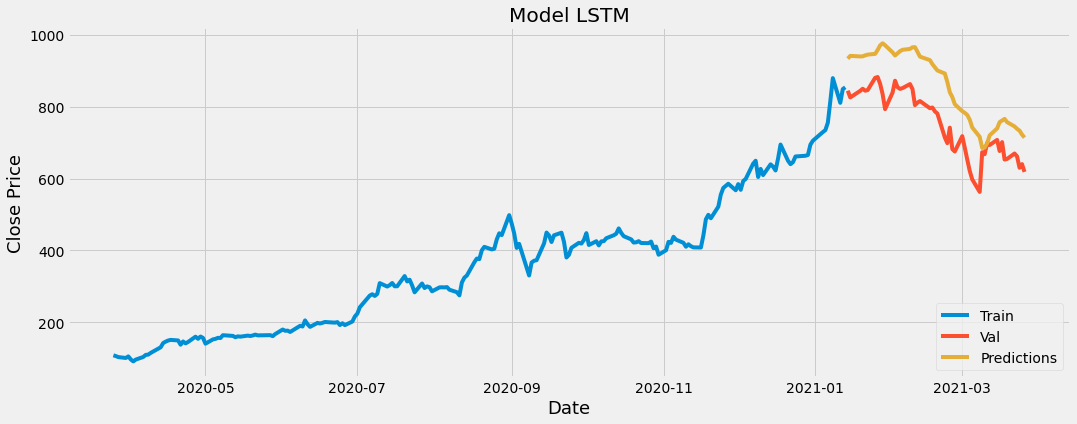

[*********************100%***********************]  1 of 1 completed


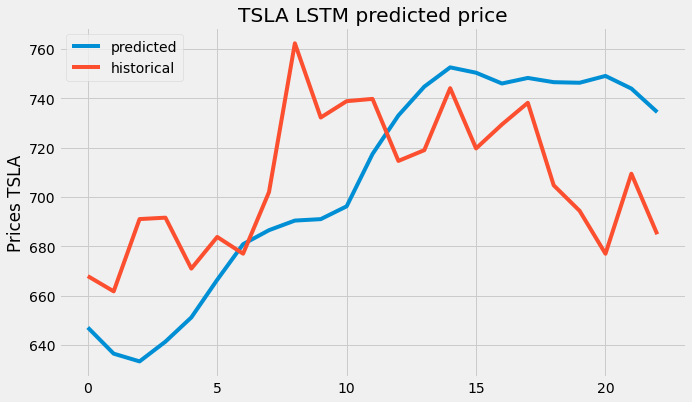

Results of ADF test


c:\users\admin\pycharmprojects\kurs4_2\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\pycharmprojects\kurs4_2\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  250
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -1119.957
Method:                       css-mle   S.D. of innovations             21.151
Date:                Mon, 02 Aug 2021   AIC                           2253.914
Time:                        12:37:14   BIC                           2278.564
Sample:                             1   HQIC                          2263.835
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.0754      1.286      1.613      0.107      -0.446       4.597
ar.L1.D.Close     0.1376      0.066      2.095      0.036       0.009       0.266
ar.L2.D.Close    -0.9478      0.024    -

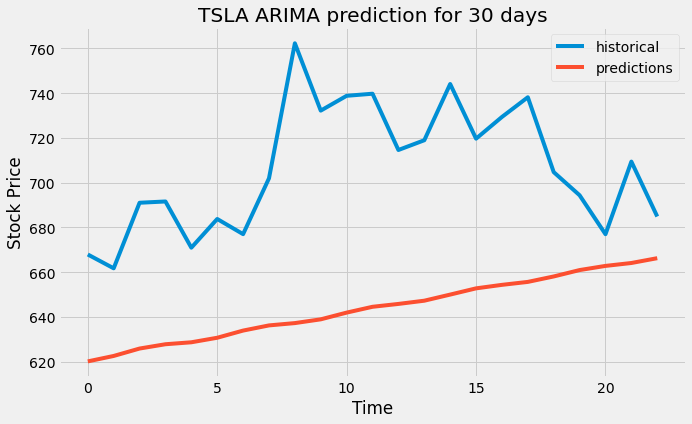

110.81818398253886


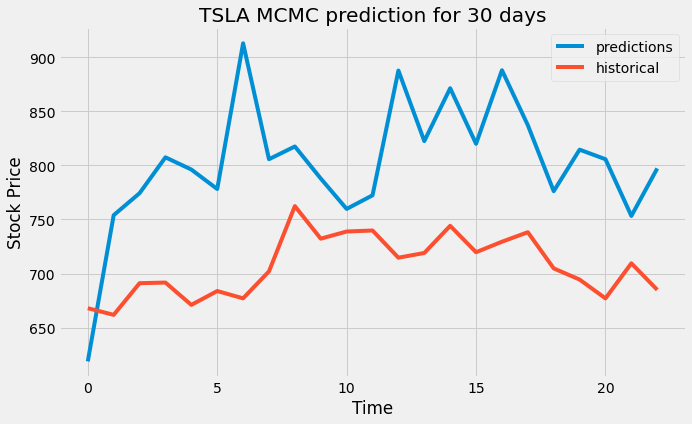

model solve
Model status:  Optimal
Optimal_weights:
MINIMIZE
-643.7823653271889*weight_arima + -705.818115234375*weight_lstm + -802.5483277601115*weight_mcmc + 706.7308694590693
SUBJECT TO
_C1: weight_arima + weight_lstm + weight_mcmc <= 1

_C2: weight_arima + weight_lstm + weight_mcmc >= 1

VARIABLES
0.02 <= weight_arima <= 0.6 Continuous
0.02 <= weight_lstm <= 0.6 Continuous
0.02 <= weight_mcmc <= 0.6 Continuous

[[629.52392263]
 [706.68204531]
 [717.76850895]
 [740.74814355]
 [737.7319229 ]
 [732.75602429]
 [819.18051436]
 [757.05254108]
 [765.61755629]
 [748.09201487]
 [733.25204591]
 [748.92129569]
 [824.12924493]
 [789.42990647]
 [821.79591759]
 [790.19546503]
 [829.38875869]
 [799.77748862]
 [762.54627305]
 [785.56326549]
 [781.33654565]
 [747.94893037]
 [770.71874492]]


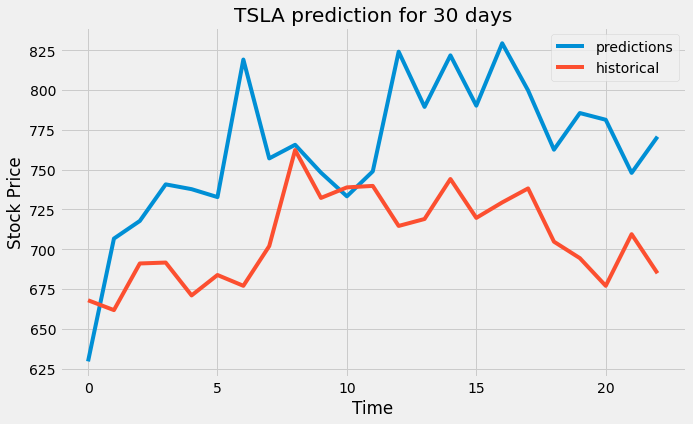

RMSE = 7.7272951523179
MCMC weight: 0.6
ARIMA weight: 0.02
LSTM weight: 0.38
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
strike_price: 630
stock_price: 706
55.889575022448696
47.936965252726566
Model status:  Undefined
Problem:
MAXIMIZE
20.110424977551304*no_call_options + -131.8895750224487*no_put_options + 0.0
SUBJECT TO
_C1: 697.067490027 no_call_options - 562.932509973 no_put_options <= 600

_C2: 697.067490027 no_call_options - 562.932509973 no_put_options >= 60

_C3: 20.1104249776 no_call_options - 131.889575022 no_put_options >= 0

VARIABLES
0 <= no_call_options Integer
0 <= no_put_options Integer

real price: 694
exp price: 706
Do not buy options!
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Epoch 1/21
144/144 [==============================] - 4s 15ms/step - loss: 0.0459 - accuracy: 0.0000e+00


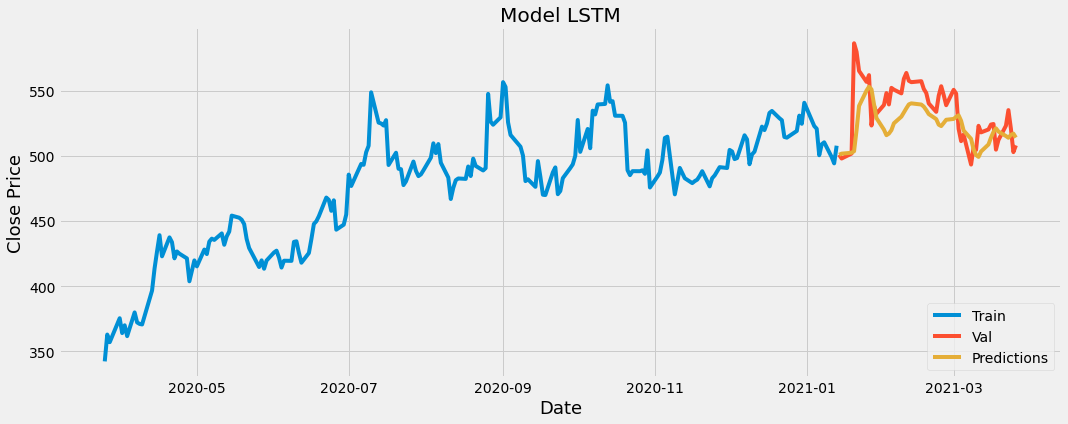

[*********************100%***********************]  1 of 1 completed


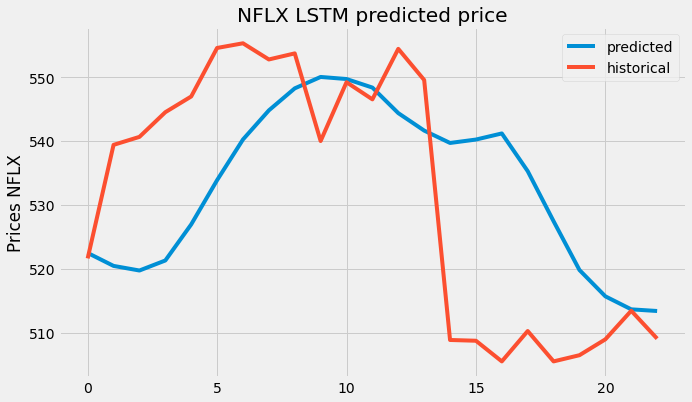

Results of ADF test
                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  250
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -996.003
Method:                       css-mle   S.D. of innovations             12.995
Date:                Mon, 02 Aug 2021   AIC                           2006.005
Time:                        12:38:22   BIC                           2030.656
Sample:                             1   HQIC                          2015.926
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5505      0.663      0.831      0.406      -0.749       1.850
ar.L1.D.Close    -1.0287      0.217     -4.734      0.000      -1.455      -0.603
ar.L2.D.Close    -0.

c:\users\admin\pycharmprojects\kurs4_2\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\pycharmprojects\kurs4_2\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


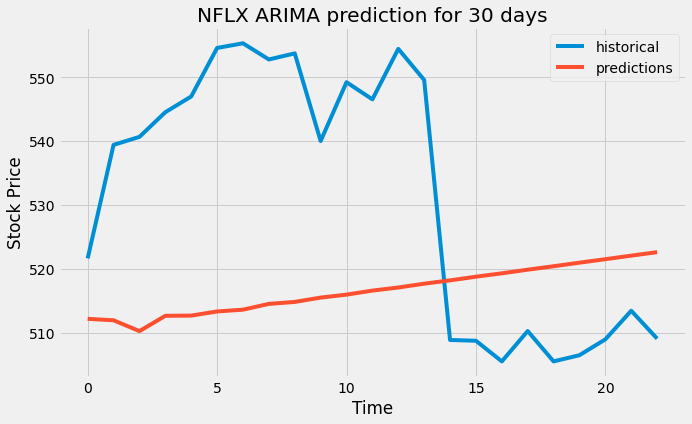

56.45686174126541


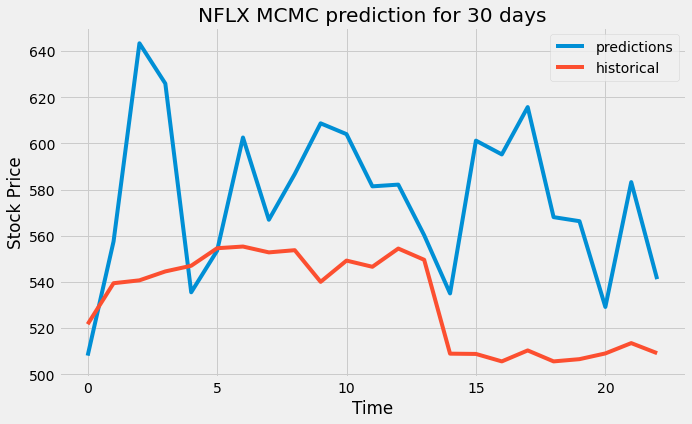

model solve
Model status:  Optimal
Optimal_weights:
MINIMIZE
-516.6597966106174*weight_arima + -533.0067775560462*weight_lstm + -576.1533495167008*weight_mcmc + 531.5930374808934
SUBJECT TO
_C1: weight_arima + weight_lstm + weight_mcmc <= 1

_C2: weight_arima + weight_lstm + weight_mcmc >= 1

VARIABLES
0.02 <= weight_arima <= 0.6 Continuous
0.02 <= weight_lstm <= 0.6 Continuous
0.02 <= weight_mcmc <= 0.6 Continuous

[[513.6297449 ]
 [542.53778165]
 [593.73902085]
 [583.91360756]
 [531.80018138]
 [545.24176615]
 [577.10569748]
 [557.46996371]
 [570.67091485]
 [584.54030717]
 [581.61331999]
 [567.54999035]
 [566.49014857]
 [552.32051948]
 [536.45291668]
 [576.39045594]
 [573.17739945]
 [583.2543621 ]
 [551.67843468]
 [547.73812083]
 [523.8854842 ]
 [555.58282254]
 [530.27597154]]


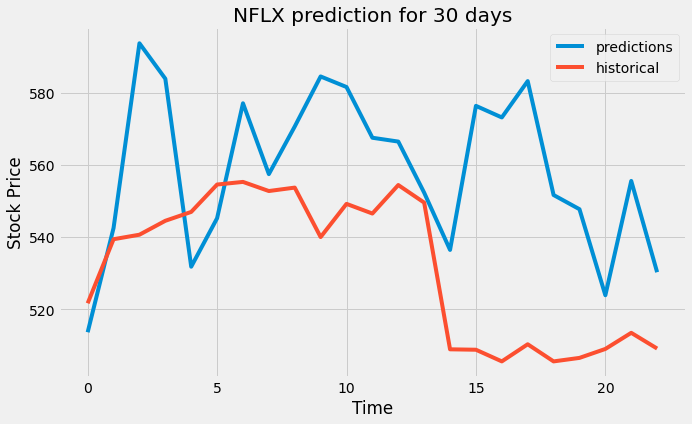

RMSE = 5.459477782264381
MCMC weight: 0.6
ARIMA weight: 0.02
LSTM weight: 0.38
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
strike_price: 520
stock_price: 542
18.440444419797416
-4.450764503126209
Model status:  Optimal
Problem:
MAXIMIZE
3.5595555802025842*no_call_options + -40.440444419797416*no_put_options + 0.0
SUBJECT TO
_C1: 542.128533304 no_call_options - 497.871466696 no_put_options <= 600

_C2: 542.128533304 no_call_options - 497.871466696 no_put_options >= 60

_C3: 3.5595555802 no_call_options - 40.4404444198 no_put_options >= 0

VARIABLES
0 <= no_call_options Integer
0 <= no_put_options Integer

real price: 506
exp price: 542
Call options: 1.0; Put options: 0.0
portfolio price: 22.1285333037569
expected profit: 3.5595555802025842
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Epoch 1/21
144/144 

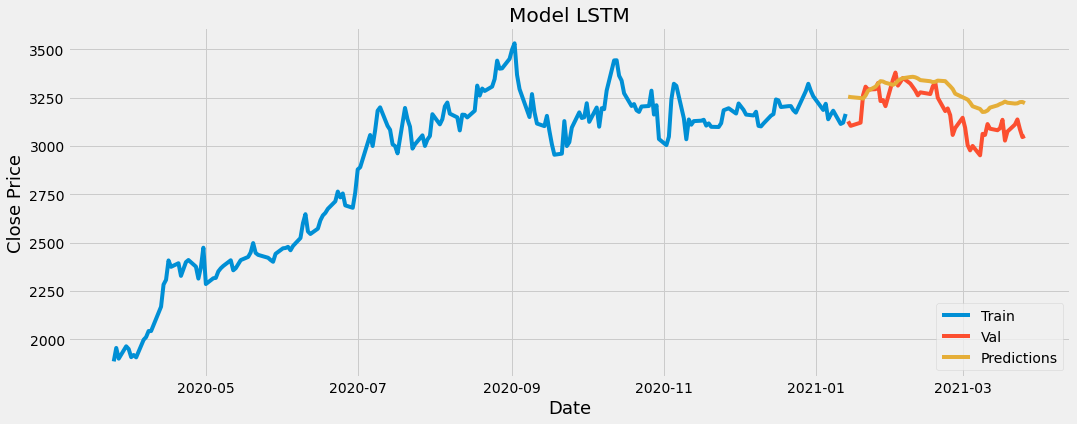

[*********************100%***********************]  1 of 1 completed


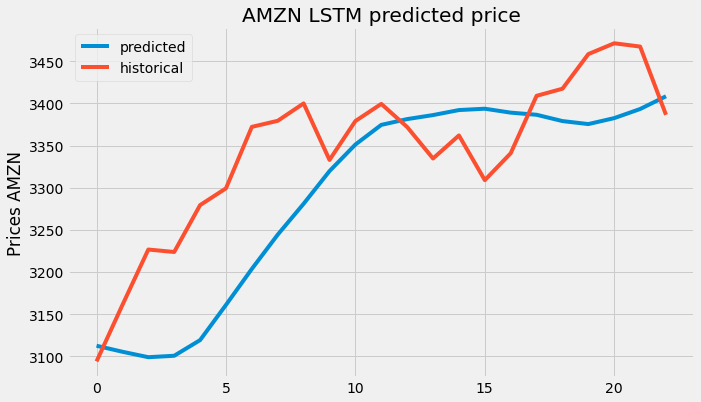

Results of ADF test
                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  250
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -1387.274
Method:                       css-mle   S.D. of innovations             62.173
Date:                Mon, 02 Aug 2021   AIC                           2788.549
Time:                        12:39:28   BIC                           2813.199
Sample:                             1   HQIC                          2798.470
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.3991      3.442      1.278      0.201      -2.347      11.145
ar.L1.D.Close    -0.5662      0.370     -1.530      0.126      -1.291       0.159
ar.L2.D.Close    -0.

c:\users\admin\pycharmprojects\kurs4_2\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\pycharmprojects\kurs4_2\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


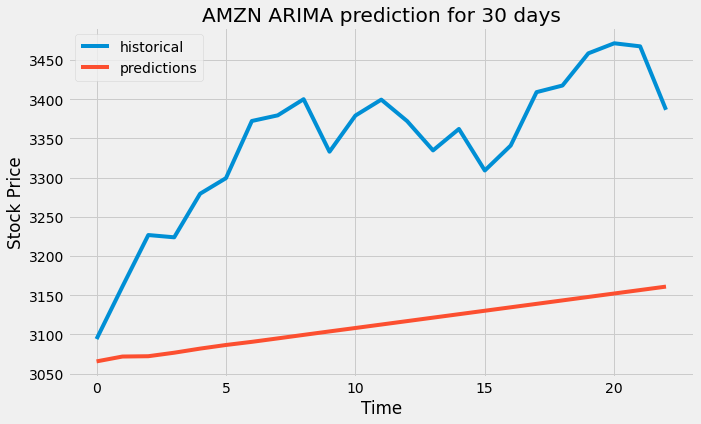

271.99855304707904


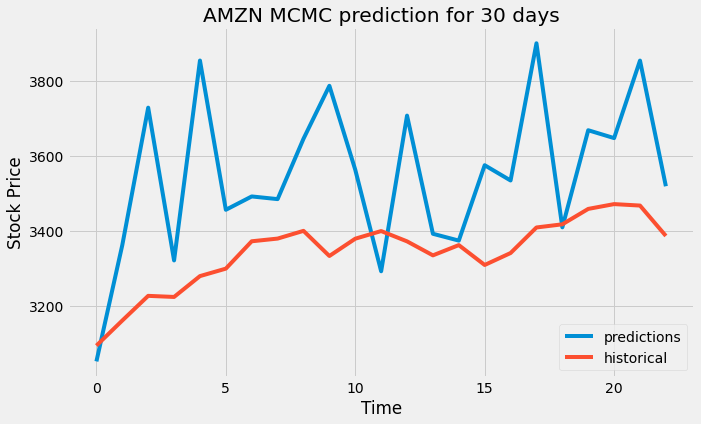

model solve
Model status:  Optimal
Optimal_weights:
MINIMIZE
-3112.6995489616675*weight_arima + -3293.0900560461955*weight_lstm + -3548.5877647798657*weight_mcmc + 3342.444771144701
SUBJECT TO
_C1: weight_arima + weight_lstm + weight_mcmc <= 1

_C2: weight_arima + weight_lstm + weight_mcmc >= 1

VARIABLES
0.02 <= weight_arima <= 0.6 Continuous
0.02 <= weight_lstm <= 0.6 Continuous
0.02 <= weight_mcmc <= 0.6 Continuous

[[3075.32747996]
 [3258.87441538]
 [3476.0929774 ]
 [3232.5337627 ]
 [3559.36521454]
 [3336.60564509]
 [3374.28616115]
 [3385.51905383]
 [3496.0836623 ]
 [3595.5533998 ]
 [3473.34408185]
 [3319.89176634]
 [3571.56913296]
 [3384.48995917]
 [3375.93504725]
 [3497.1881938 ]
 [3471.07500652]
 [3689.65317722]
 [3392.49876188]
 [3546.57400103]
 [3536.77728709]
 [3664.94312938]
 [3469.77819721]]


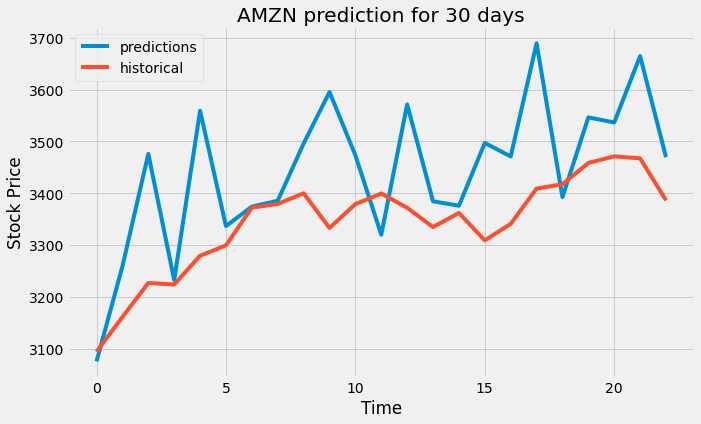

RMSE = 10.53811645478392
MCMC weight: 0.6
ARIMA weight: 0.02
LSTM weight: 0.38
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
strike_price: 3087
stock_price: 3258
136.07204032830987
264.1805521494516
Model status:  Optimal
Problem:
MAXIMIZE
34.92795967169013*no_call_options + -307.07204032830987*no_put_options + 0.0
SUBJECT TO
_C1: 3250.28644839 no_call_options - 2923.71355161 no_put_options <= 9000

_C2: 3250.28644839 no_call_options - 2923.71355161 no_put_options >= 900

_C3: 34.9279596717 no_call_options - 307.072040328 no_put_options >= 0

VARIABLES
0 <= no_call_options Integer
0 <= no_put_options Integer

real price: 3458
exp price: 3258
Call options: 2.0; Put options: 0.0
portfolio price: 326.5728967879437
expected profit: 69.85591934338026
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Epoch 1/21
144

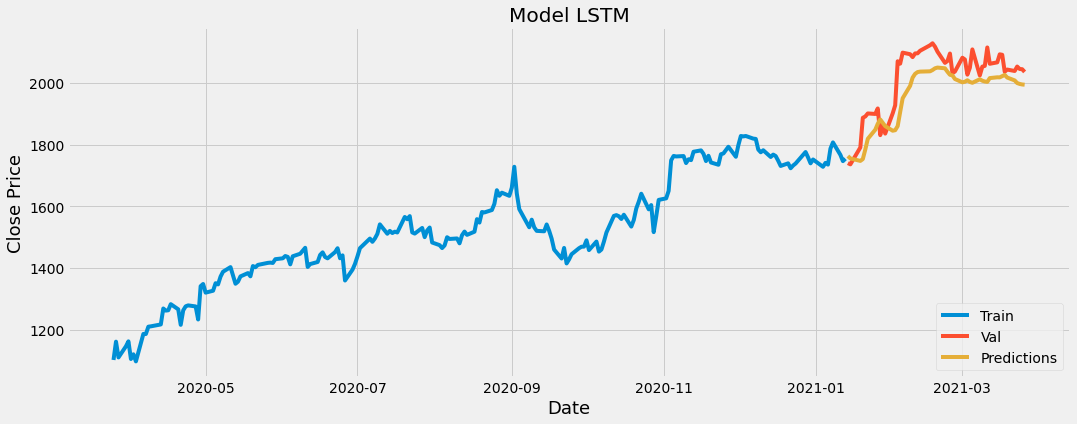

[*********************100%***********************]  1 of 1 completed


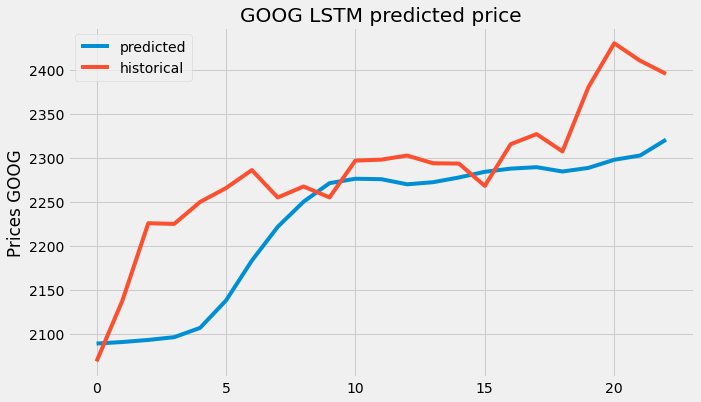

Results of ADF test
                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  250
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -1212.084
Method:                       css-mle   S.D. of innovations             30.854
Date:                Mon, 02 Aug 2021   AIC                           2438.168
Time:                        12:40:33   BIC                           2462.819
Sample:                             1   HQIC                          2448.089
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.5770      1.540      2.323      0.020       0.560       6.594
ar.L1.D.Close    -0.0804      0.378     -0.213      0.832      -0.821       0.661
ar.L2.D.Close     0.

c:\users\admin\pycharmprojects\kurs4_2\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\pycharmprojects\kurs4_2\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


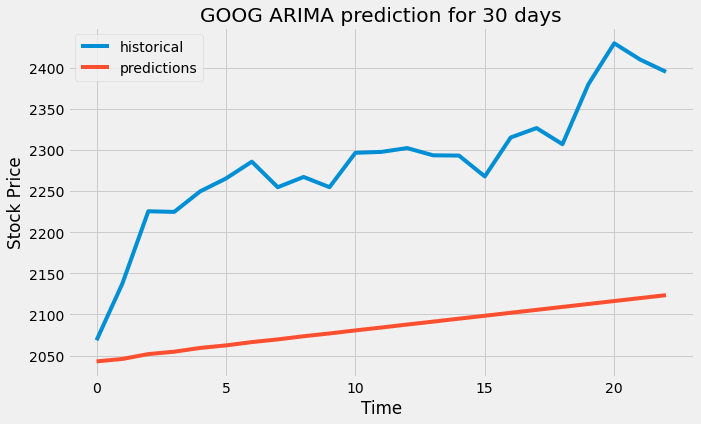

156.24975918291562


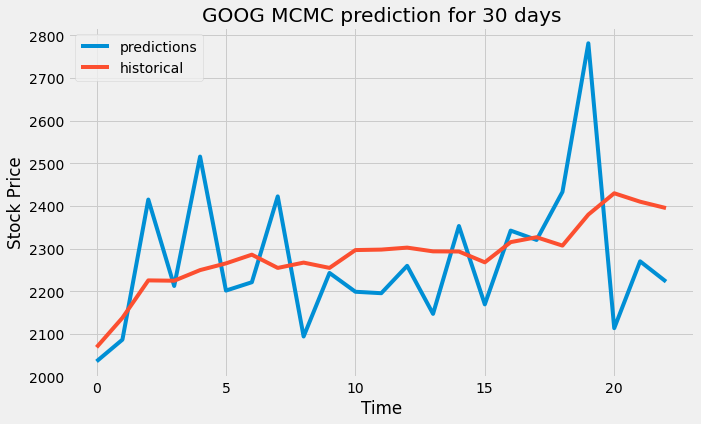

model solve
Model status:  Optimal
Optimal_weights:
MINIMIZE
-2083.9005292149664*weight_arima + -2228.8468389096465*weight_lstm + -2271.978739897804*weight_mcmc + 2284.8038913892665
SUBJECT TO
_C1: weight_arima + weight_lstm + weight_mcmc <= 1

_C2: weight_arima + weight_lstm + weight_mcmc >= 1

VARIABLES
0.02 <= weight_arima <= 0.6 Continuous
0.02 <= weight_lstm <= 0.6 Continuous
0.02 <= weight_mcmc <= 0.6 Continuous

[[2055.96029297]
 [2087.32289207]
 [2285.49110373]
 [2165.07164614]
 [2351.32893881]
 [2174.55645307]
 [2203.63442883]
 [2339.09698272]
 [2152.83705401]
 [2250.34804836]
 [2225.8479239 ]
 [2223.68127096]
 [2260.0936566 ]
 [2193.43228485]
 [2319.20733613]
 [2211.4213847 ]
 [2316.68053794]
 [2304.2562998 ]
 [2370.11588662]
 [2580.83377924]
 [2183.46105853]
 [2279.48183791]
 [2257.86097198]]


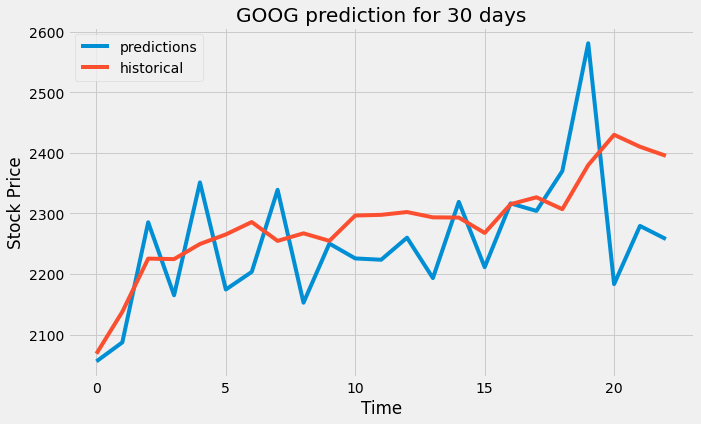

RMSE = 8.926502526129307
MCMC weight: 0.6
ARIMA weight: 0.02
LSTM weight: 0.38
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
strike_price: 2045
stock_price: 2087
43.74854850777592
227.09854426796755
Model status:  Infeasible
Problem:
MAXIMIZE
-1.7485485077759222*no_call_options + -85.74854850777592*no_put_options + 0.0
SUBJECT TO
_C1: 2097.49825821 no_call_options - 1992.50174179 no_put_options <= 9000

_C2: 2097.49825821 no_call_options - 1992.50174179 no_put_options >= 900

_C3: - 1.74854850778 no_call_options - 85.7485485078 no_put_options >= 0

VARIABLES
0 <= no_call_options Integer
0 <= no_put_options Integer

real price: 2379
exp price: 2087
Do not buy options!
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Epoch 1/21
144/144 [==============================] - 4s 15ms/step - loss: 0.0889 - accuracy: 

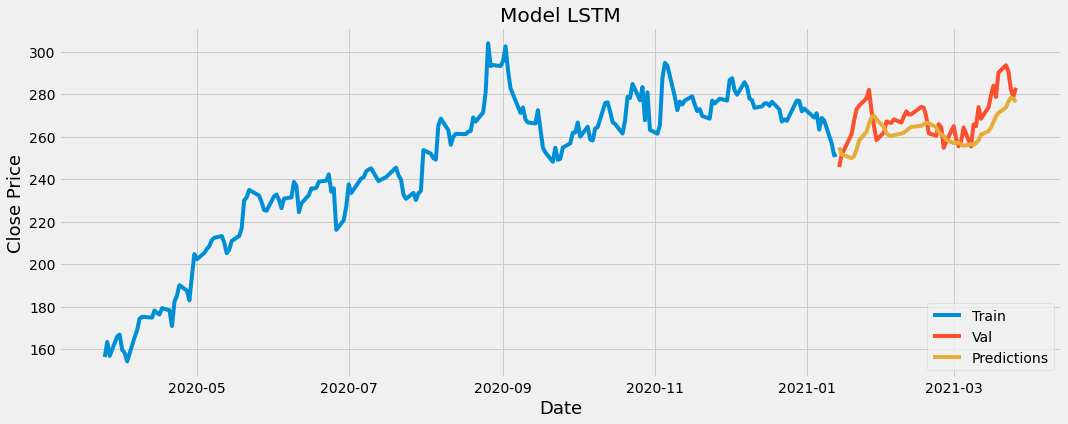

[*********************100%***********************]  1 of 1 completed


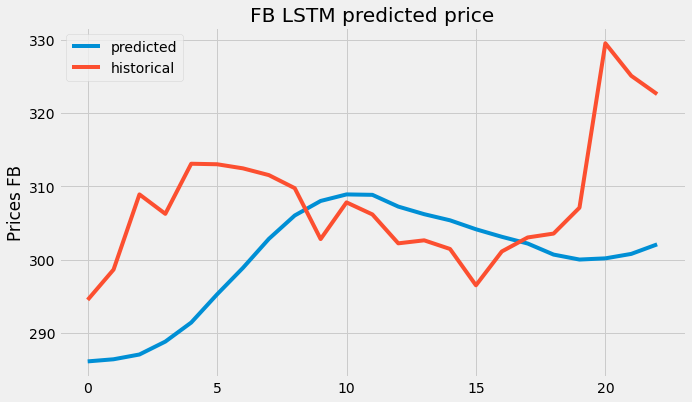

Results of ADF test
                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  250
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -794.951
Method:                       css-mle   S.D. of innovations              5.815
Date:                Mon, 02 Aug 2021   AIC                           1603.902
Time:                        12:41:38   BIC                           1628.552
Sample:                             1   HQIC                          1613.823
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.4726      0.326      1.448      0.148      -0.167       1.112
ar.L1.D.Close    -0.5413      0.273     -1.983      0.047      -1.076      -0.006
ar.L2.D.Close    -0.

c:\users\admin\pycharmprojects\kurs4_2\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\pycharmprojects\kurs4_2\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


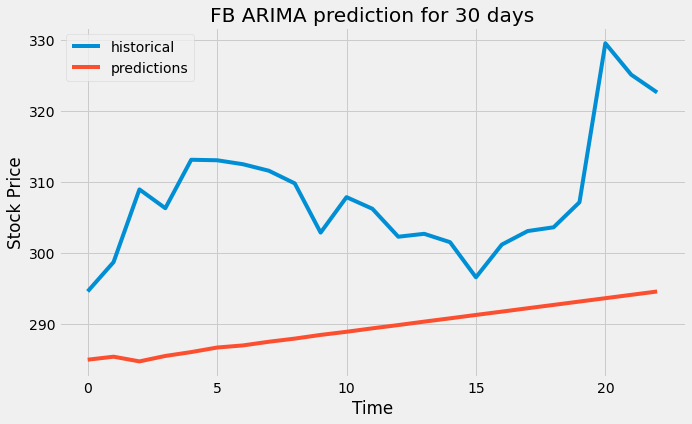

21.492606643956808


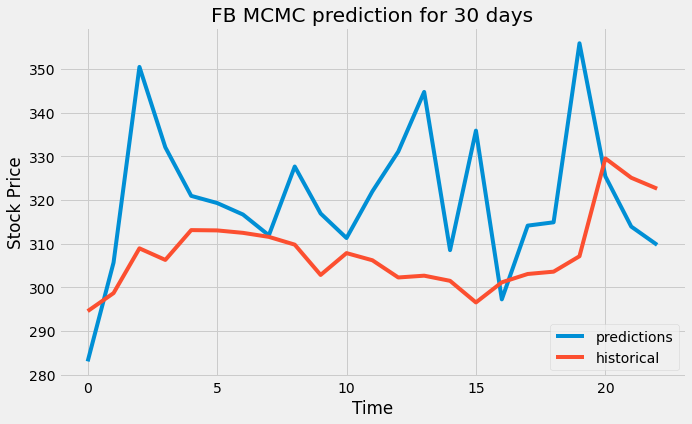

model solve
Model status:  Optimal
Optimal_weights:
MINIMIZE
-289.36652705772474*weight_arima + -300.04162863026494*weight_lstm + -320.3928678757058*weight_mcmc + 307.8234783670177
SUBJECT TO
_C1: weight_arima + weight_lstm + weight_mcmc <= 1

_C2: weight_arima + weight_lstm + weight_mcmc >= 1

VARIABLES
0.02 <= weight_arima <= 0.6 Continuous
0.02 <= weight_lstm <= 0.6 Continuous
0.02 <= weight_mcmc <= 0.6 Continuous

[[284.24542836]
 [297.94706727]
 [325.06630533]
 [314.70272242]
 [309.02598676]
 [309.51811905]
 [309.31360088]
 [307.9692938 ]
 [318.64110894]
 [312.94880852]
 [309.92726688]
 [316.32568522]
 [321.19468454]
 [329.00836095]
 [306.95959087]
 [322.92632327]
 [299.35710663]
 [309.1529764 ]
 [309.04641355]
 [333.39896017]
 [315.18279657]
 [308.5220295 ]
 [306.51334328]]


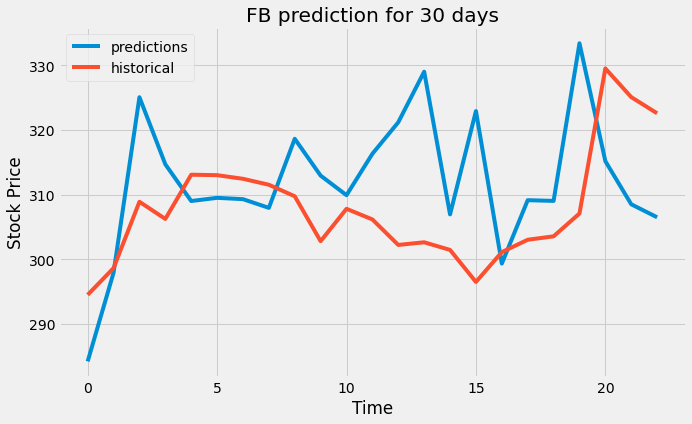

RMSE = 3.263529588929993
MCMC weight: 0.6
ARIMA weight: 0.02
LSTM weight: 0.38
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
strike_price: 282
stock_price: 297
12.019076352206156
18.41668889910642
Model status:  Optimal
Problem:
MAXIMIZE
2.980923647793844*no_call_options + -27.019076352206156*no_put_options + 0.0
SUBJECT TO
_C1: 296.422891623 no_call_options - 267.577108377 no_put_options <= 600

_C2: 296.422891623 no_call_options - 267.577108377 no_put_options >= 60

_C3: 2.98092364779 no_call_options - 27.0190763522 no_put_options >= 0

VARIABLES
0 <= no_call_options Integer
0 <= no_put_options Integer

real price: 307
exp price: 297
Call options: 2.0; Put options: 0.0
portfolio price: 28.845783245294776
expected profit: 5.961847295587688
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Epoch 1/21
144/144 

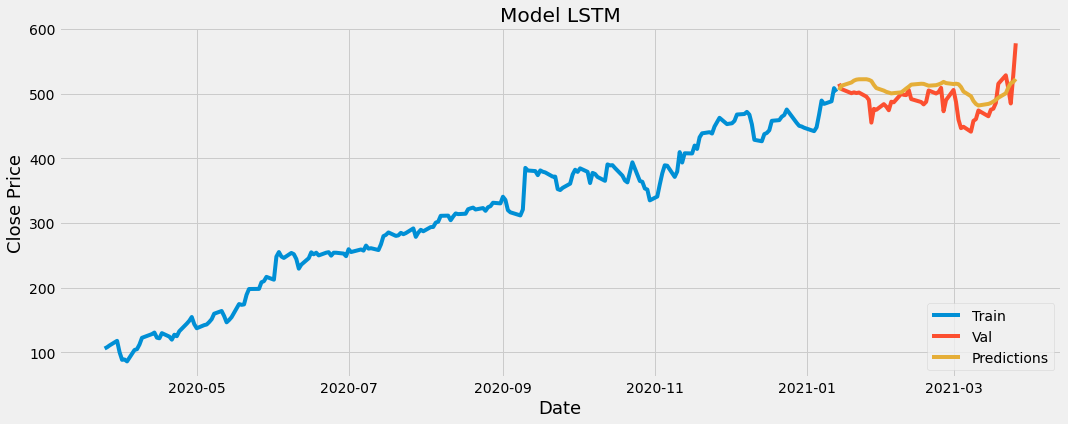

[*********************100%***********************]  1 of 1 completed


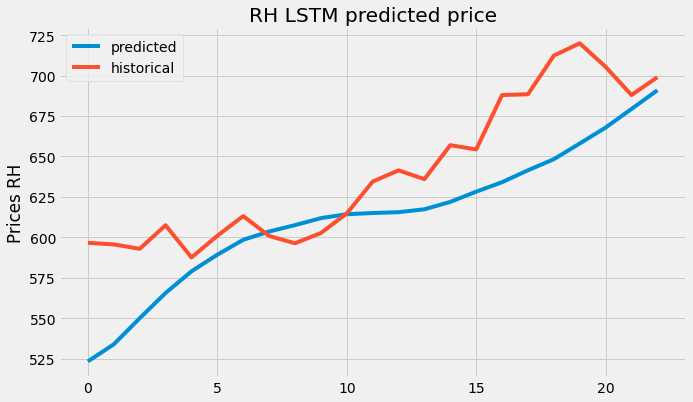

Results of ADF test
                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  250
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -965.348
Method:                       css-mle   S.D. of innovations             11.499
Date:                Mon, 02 Aug 2021   AIC                           1944.696
Time:                        12:42:44   BIC                           1969.346
Sample:                             1   HQIC                          1954.617
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.8005      0.560      3.216      0.001       0.703       2.898
ar.L1.D.Close    -0.1035      0.818     -0.127      0.899      -1.707       1.500
ar.L2.D.Close     0.

c:\users\admin\pycharmprojects\kurs4_2\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\pycharmprojects\kurs4_2\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


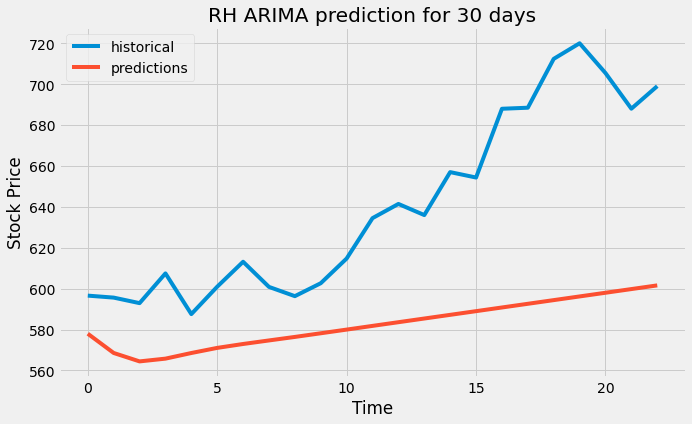

49.78596376709426


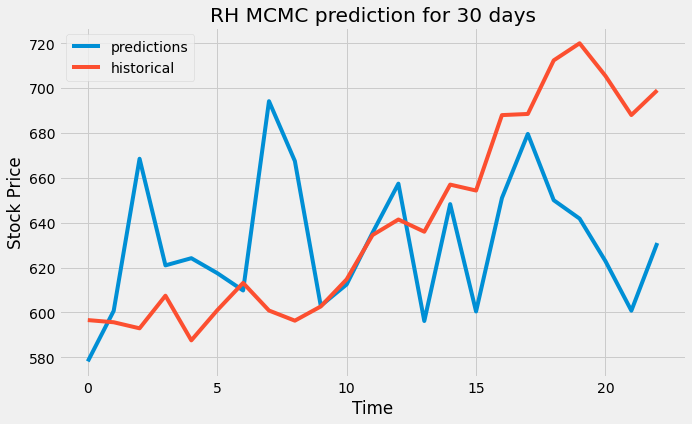

model solve
Model status:  Optimal
Optimal_weights:
MINIMIZE
-582.56345248592*weight_arima + -612.8309777301291*weight_lstm + -630.9613262162039*weight_mcmc + 640.5934740149456
SUBJECT TO
_C1: weight_arima + weight_lstm + weight_mcmc <= 1

_C2: weight_arima + weight_lstm + weight_mcmc >= 1

VARIABLES
0.02 <= weight_arima <= 0.6 Continuous
0.02 <= weight_lstm <= 0.6 Continuous
0.02 <= weight_mcmc <= 0.6 Continuous

[[557.31741713]
 [574.65862254]
 [621.40075198]
 [598.83764944]
 [605.89689361]
 [605.86563532]
 [604.75456253]
 [657.38171509]
 [642.89716174]
 [605.86396256]
 [612.53092852]
 [626.66920663]
 [640.0449252 ]
 [604.00926982]
 [637.06351023]
 [610.7746697 ]
 [643.3994929 ]
 [663.36927513]
 [648.28694525]
 [647.08431289]
 [639.47228663]
 [630.63964653]
 [653.16931824]]


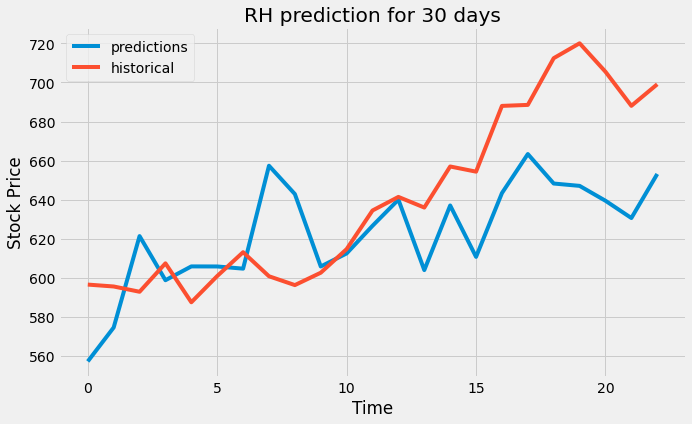

RMSE = 5.588085427843007
MCMC weight: 0.6
ARIMA weight: 0.02
LSTM weight: 0.38
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
strike_price: 485
stock_price: 574
65.05707057147049
164.69036115775344
Model status:  Optimal
Problem:
MAXIMIZE
23.94292942852951*no_call_options + -154.0570705714705*no_put_options + 0.0
SUBJECT TO
_C1: 563.068484686 no_call_options - 406.931515314 no_put_options <= 1200

_C2: 563.068484686 no_call_options - 406.931515314 no_put_options >= 120

_C3: 23.9429294285 no_call_options - 154.057070571 no_put_options >= 0

VARIABLES
0 <= no_call_options Integer
0 <= no_put_options Integer

real price: 720
exp price: 574
Call options: 2.0; Put options: 0.0
portfolio price: 156.13696937152918
expected profit: 47.88585885705902
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Epoch 1/21
144/144

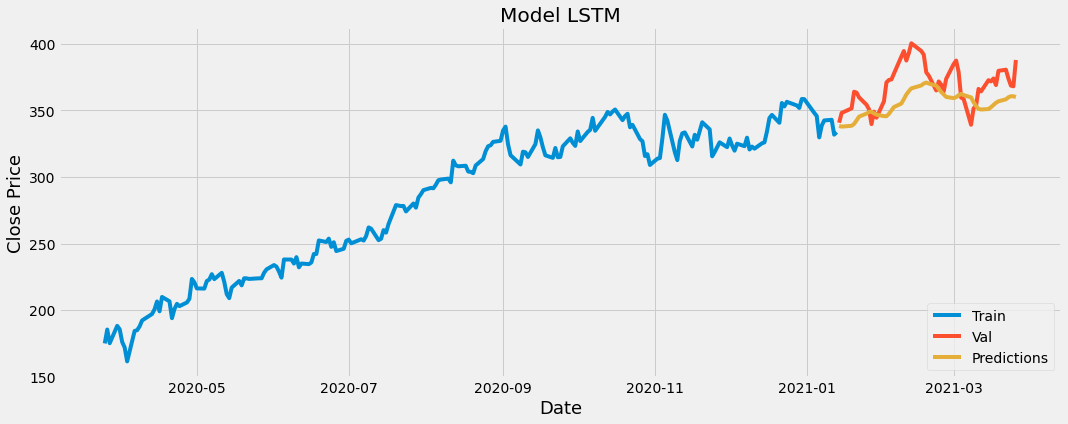

[*********************100%***********************]  1 of 1 completed


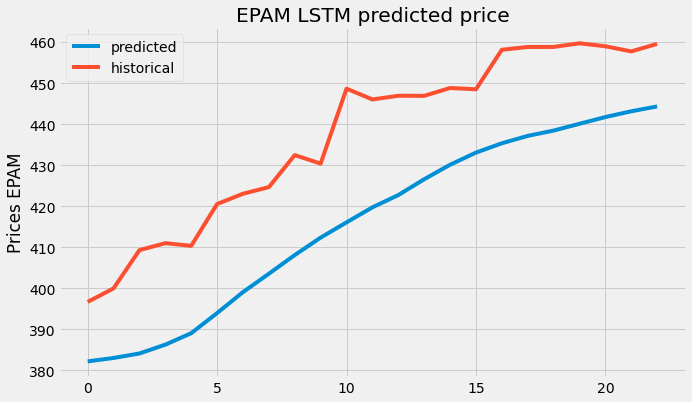

Results of ADF test
                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  250
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -837.765
Method:                       css-mle   S.D. of innovations              6.900
Date:                Mon, 02 Aug 2021   AIC                           1689.529
Time:                        12:43:50   BIC                           1714.179
Sample:                             1   HQIC                          1699.450
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.7891      0.207      3.820      0.000       0.384       1.194
ar.L1.D.Close    -0.0454      0.126     -0.361      0.718      -0.292       0.201
ar.L2.D.Close     0.

c:\users\admin\pycharmprojects\kurs4_2\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\pycharmprojects\kurs4_2\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


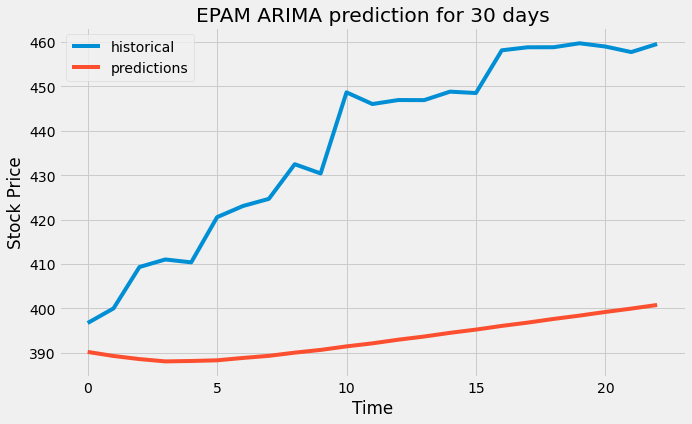

27.296459812721977


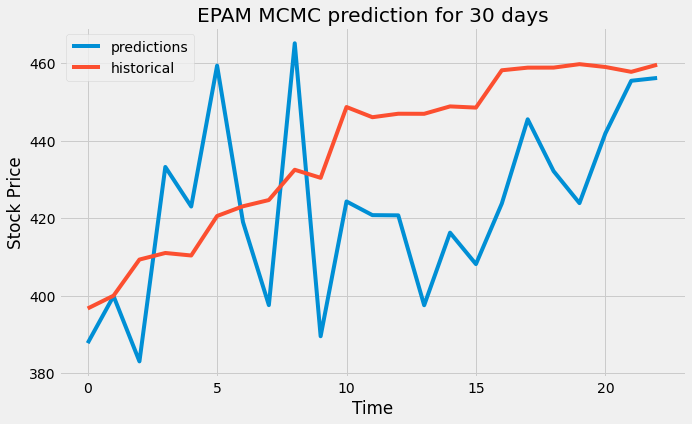

model solve
Model status:  Optimal
Optimal_weights:
MINIMIZE
-393.02915955660575*weight_arima + -416.10427325704825*weight_lstm + -422.7771012548447*weight_mcmc + 437.2313033394192
SUBJECT TO
_C1: weight_arima + weight_lstm + weight_mcmc <= 1

_C2: weight_arima + weight_lstm + weight_mcmc >= 1

VARIABLES
0.02 <= weight_arima <= 0.6 Continuous
0.02 <= weight_lstm <= 0.6 Continuous
0.02 <= weight_mcmc <= 0.6 Continuous

[[385.68017172]
 [393.26854796]
 [383.55731824]
 [414.46836524]
 [409.40678729]
 [433.08222304]
 [410.82905681]
 [399.6665788 ]
 [441.95114085]
 [398.22673887]
 [420.519668  ]
 [419.80928429]
 [420.9270213 ]
 [408.48835989]
 [421.08361822]
 [417.35530298]
 [427.62371212]
 [441.3578114 ]
 [433.84208233]
 [429.53515959]
 [440.9613959 ]
 [449.66430717]
 [450.56405571]]


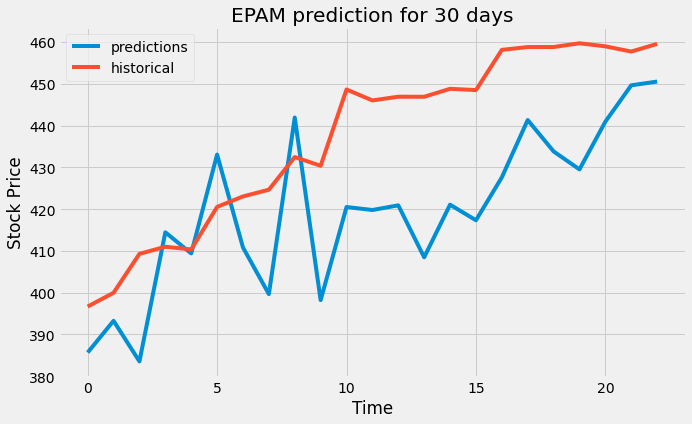

RMSE = 4.449595537414874
MCMC weight: 0.6
ARIMA weight: 0.02
LSTM weight: 0.38
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
strike_price: 368
stock_price: 393
19.300129187669995
61.86684213353627
Model status:  Optimal
Problem:
MAXIMIZE
5.699870812330005*no_call_options + -44.300129187669995*no_put_options + 0.0
SUBJECT TO
_C1: 391.160155025 no_call_options - 344.839844975 no_put_options <= 9000

_C2: 391.160155025 no_call_options - 344.839844975 no_put_options >= 900

_C3: 5.69987081233 no_call_options - 44.3001291877 no_put_options >= 0

VARIABLES
0 <= no_call_options Integer
0 <= no_put_options Integer

real price: 459
exp price: 393
Call options: 23.0; Put options: 0.0
portfolio price: 532.6835655796918
expected profit: 131.0970286835901
total expected profit for options: 276.42050546557533
expected profit for options in %: 0.036856067395410044%
total real profit for options: 1106.732454304

In [18]:
def main():
    total_sum = 150000.0
    portfolio(total_sum)


main()